<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/JettCampU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: Making a Generalized Linear Model (1 predictor)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In this project, I want to determine the linear relationship between professional soccer player's ages and their annual wage. The dataset I'm using consists of every soccer player in all the major leagues around the world, and each of their major indentifying information like wage, age, club, etc.

In [ ]:
#raw csv soccer data
path = 'https://raw.githubusercontent.com/jettecampbell/data-science/refs/heads/main/SalaryPrediction.csv'

In [ ]:
data = pd.read_csv(path,dtype={'League':'category'})

In [ ]:
data

,Wage,Age,Club,League,Nation,Position,Apps,Caps
0,"46,427,000",23,PSG,Ligue 1 Uber Eats,FRA,Forward,190,57
1,"42,125,000",30,PSG,Ligue 1 Uber Eats,BRA,Midfilder,324,119
2,"34,821,000",35,PSG,Ligue 1 Uber Eats,ARG,Forward,585,162
3,"19,959,000",31,R. Madrid,La Liga,BEL,Forward,443,120
4,"19,500,000",31,Man UFC,Premier League,ESP,Goalkeeper,480,45
...,...,...,...,...,...,...,...,...
3902,"3,400",19,Vigo,La Liga,ESP,Defender,0,0
3903,"3,200",18,Famalicao,Primiera Liga,BRA,Goalkeeper,0,0
3904,"2,900",18,Vigo,La Liga,ESP,Forward,0,0
3905,"2,700",18,Vigo,La Liga,ESP,Defender,0,0


I realized that the dataset I imported used string variables for the wage category which wouldn't work if I tried to graph this. To fix this, I created a block of code that goes through each player in my dataset and turned the wage string into a integer. While I was at it, I put all the new wage values into a new dataset along with each player's age because those are the categories I will be using for my linear representation.

In [ ]:
#creates new empty data frame with the categories I need
players = pd.DataFrame(columns = ['wage', 'age'])
index = 0 #keep track of where I am in the dataframe
for x in data.Wage: #goes through each wage in my data
  new_wage = int(data.Wage[index].replace(',','')) #creates a new integer wage from each string wage
  players.loc[len(players.index)] = [new_wage, data.Age[index]] #adds wage and age to new dataframe
  index += 1
  #if index > 99:
    #break

In [ ]:
players

,wage,age
0,46427000,23
1,42125000,30
2,34821000,35
3,19959000,31
4,19500000,31
...,...,...
3902,3400,19
3903,3200,18
3904,2900,18
3905,2700,18


Now I could plot my data on a scatterplot with age as the x-axis and wage as the y-axis. I expected to see a positive trend between age and wage because the players that stay in the league longer are most likely the star players and paid more to keep playing. After plotting my data however, I noticed there wasn't much of a relatioship between the two variables, possibly due to the sheer amount of data in my dataset.

<Axes: xlabel='age', ylabel='wage'>

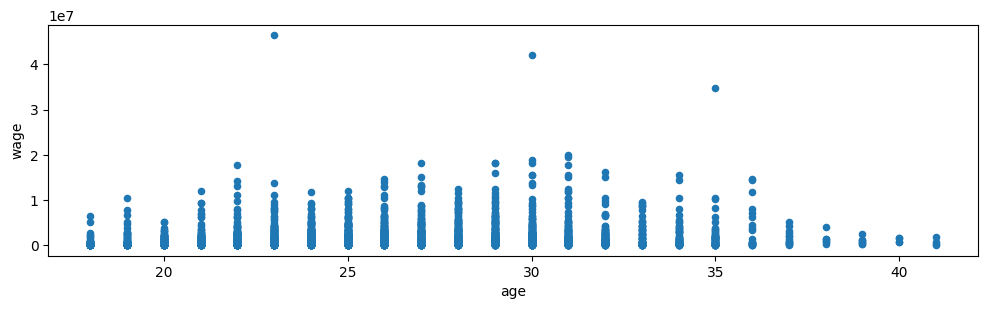

In [ ]:
players.plot(x="age", y="wage", figsize=(12, 3), kind="scatter")

To fix this and make the data better work with the model, I first removed the obvious extreme outliers. This would make the graph more readable and make it easier to predict the data as a whole. I also cut out a bulk of the low values, bringing the number of data points from almost 4000 to just over 100 so the model would better represent the major soccer leagues and not all the players that are paid just $1000 a year.

In [ ]:
players = players.query('wage < 30000000') #removes all players with a wage over 30 million
players = players.query('wage > 8000000') #removes all players with a wage under 8 million

In [ ]:
players

,wage,age
3,19959000,31
4,19500000,31
5,18810000,30
6,18200000,29
7,18200000,30
...,...,...
108,8320000,23
109,8290000,28
110,8190000,23
111,8151000,29


Plotting the new, smaller data set showed more of the postive trend I originally expected. Although the data is pretty varied, it definetly shows a slight positve trend.

<Axes: xlabel='age', ylabel='wage'>

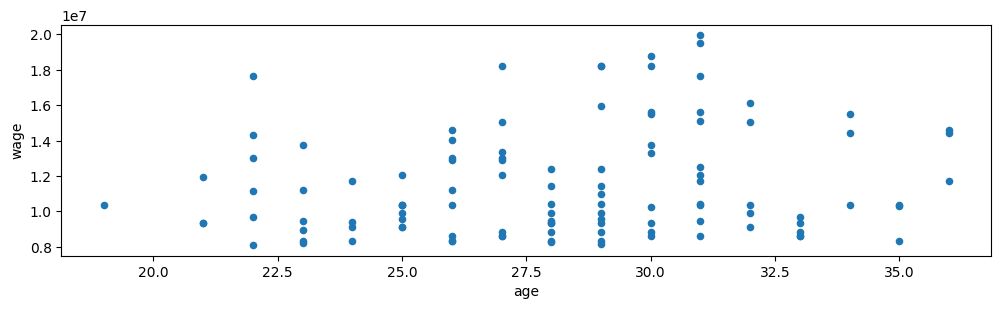

In [ ]:
players.plot(x="age", y="wage", figsize=(12, 3), kind="scatter")

I chose to use a negative binomial model for my data because all the wages will be postive. The wages are also more concentrated on the lower end, and the negative binomial model will create a exponential line which matches this trend.

In [ ]:
#nbp stands for negative binomial players model
with pm.Model() as model_nbp:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * players.age))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=players.wage)

    idata_nbp = pm.sample()

Output()

Output()

In [ ]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(idata_nbp, model = model_nbp, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

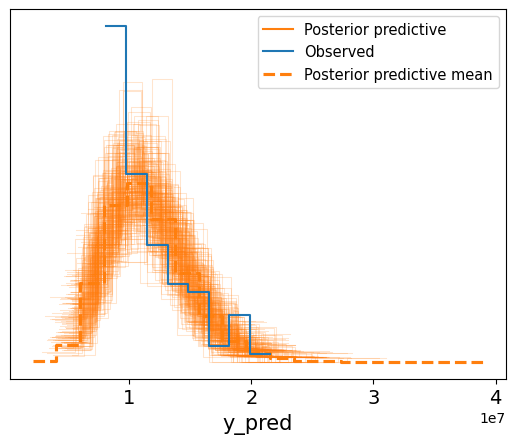

In [ ]:
# posterior predictive check
az.plot_ppc(idata_nbp, num_pp_samples=200, colors=["C1", "C0", "C1"])

This postier predictive mean matched the observed data well and matched the distinct curve. Next I had to plot the postier predictive distribution with a line of best fit to show the predicted trend of my variables.

Text(0, 0.5, 'Annual Wage')

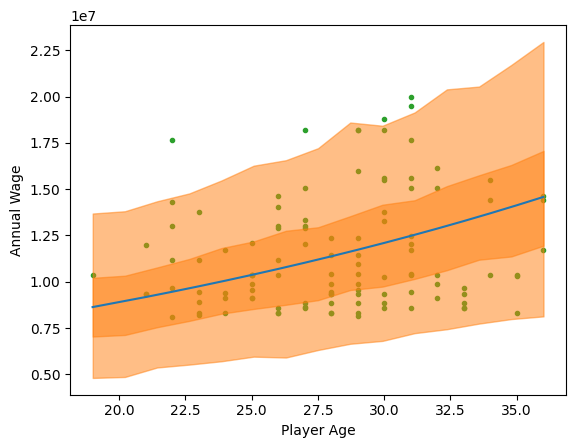

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_nbp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
ages = np.random.normal(players.age.values, 0.01)
idx = np.argsort(ages)
x = np.linspace(ages.min(), ages.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_nbp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ages[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(players.age, players.wage, "C2.", zorder=-3)
ax.plot(players.age.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")

#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Player Age")
ax.set_ylabel("Annual Wage")

The postier plot could be better, but it fits the data for the most part. The data is pretty varied so its hard to make a line of best fit that matches perfectly. In the future, I might be able to see a more distinct trend if I limited the data to just a certain soccer league such as the Premier League because leagues in general differ in the average player wage, meaning a 18 year old in the MLS may be payed much less on average than a 18 year old in La Liga.